In [1]:
import numpy as np
from tqdm.notebook import tqdm
from itertools import combinations
import matplotlib.pyplot as plt
from utils import RFsLDA

from sklearn.decomposition import FastICA
from coroica import CoroICA, UwedgeICA

from scipy.special import comb
import seaborn as sns
import pandas as pd

from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from timeit import default_timer

In [2]:
n_ses = [273, 281, 270, 283, 270, 273, 262, 228, 262, 276, 219, 215, 271, 277, 264, 271, 237, 264]
#n_ses = [273, 281, 270, 273, 262, 228, 262, 276, 219, 215, 271, 277, 264, 271, 237, 264]

In [3]:
Classes= np.load('Class_CAR_nofilt.npy')

In [4]:
Signals =np.load("Signals_CAR_nofilt.npy")

In [5]:
print(Classes.shape, Signals.shape, Signals.dtype)

(4696,) (4696, 21, 750) float32


# Try to sanitycheck classifyer on raw data

In [ ]:
X_test = np.log(np.var(Signals, axis = 2))

In [ ]:
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X_test, Classes)

In [ ]:
predicts = clf.predict(X_test)
np.mean(predicts==Classes)

# Try ICA

In [ ]:
Sig1,Sig2, I, L = Signals_pipeline(range(1,3))

In [ ]:
transformer = FastICA(n_components=21, tol=0.01,random_state=0)
X1 = transformer.fit_transform(Sig1)
print(X1.shape)
X2 =  transformer.transform(Sig2)

In [ ]:
X1,X2 = X1.transpose(), X2.transpose()
X1,X2 = X1.reshape((21, len(I), 750)),X2.reshape(21,len(L),750)

# Bandpass filter and bandpower features

In [6]:
from scipy.signal import butter, lfilter

lowcut = 8
highcut = 30
fs = 250 # sampling frequency
order = 3
nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq
b, a = butter(order, [low, high], btype='band')

In [ ]:
#Apply bandpass filters
Filt1,Filt2 = lfilter(b,a,X1),lfilter(b,a,X2)

## Extract bandpower features
Features1,Features2 = np.log(np.var(Filt1, axis = 2)),np.log(np.var(Filt2, axis = 2))
Features1,Features2 = Features1.transpose(),Features2.transpose()

# Try classifying on ica's banpowers

In [ ]:
clf = svm.SVC(decision_function_shape='ovo', kernel = "linear")
clf.fit(Features1, Classes[I])

In [ ]:
predicts = clf.predict(Features2)
np.mean(predicts==Classes[L])

In [ ]:
clf = QuadraticDiscriminantAnalysis(reg_param=0.1)
clf.fit(Features1, Classes[I])

In [ ]:
predicts = clf.predict(Features2)
np.mean(predicts==Classes[L])

# Pipeline

In [7]:
def Indices(persons):
    ans = []
    for p in persons:
        a = sum(n_ses[:2*p])
        b = sum(n_ses[:2*p+2])
        ans += list(range(a,b))
    return ans

In [8]:
def reshape_signal(arr):
    x,y,z = arr.shape
    a = np.stack(arr, axis = 1)
    a = a.reshape((y, x*z))
    return a.transpose()

In [9]:
N_list = range(sum(n_ses))
def Signals_pipeline(persons):
    I = Indices(persons)
    LeaveOut = list(set(N_list) - set(I))

    ## Get signals and reshape
    Signals1,Signals2 = Signals[I], Signals[LeaveOut]
    return reshape_signal(Signals1),reshape_signal(Signals2), I, LeaveOut

In [10]:
def ICA_METHODS():
    return {
        "CoroICA":CoroICA(partitionsize= int(20 * 200),
                          max_iter =6000,
                          n_components=21,
                          groupsize = int(510*750),
                          minimize_loss=False,
                          condition_threshold=1000,
                          pairing='neighbouring'),
        "choiICA": UwedgeICA(partitionsize= int(15 * 200),
                             n_components=21,
                             condition_threshold=1000,
                             instantcov=True,
                             timelags=None),
        "FastICA":FastICA(n_components=21,max_iter = 100)
    }
def Classifier():
    return {
        "SVM": svm.SVC(decision_function_shape='ovo', kernel = "linear"),
        "RF": RandomForestClassifier(n_estimators = 10000,max_depth = 5),
        "LDA":LinearDiscriminantAnalysis(),
        "QDA":QuadraticDiscriminantAnalysis(reg_param=0.08),
        "AdaBoost":AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),n_estimators=600,learning_rate=1),
        "MLP": MLPClassifier(random_state=1, max_iter=10000),
        "RFsLDA": RFsLDA()
    }

In [11]:
def ICA_pipeline(method, Signals1, Signals2, I, LeaveOut, timer = True, classifier = "SVM"):
        ## Apply ICA
        transformer = ICA_METHODS()[method]
        start = default_timer()
        X = transformer.fit_transform(Signals1)
        Y = transformer.transform(Signals2)
        end = default_timer()
        X,Y = X.transpose(), Y.transpose()
        X,Y = X.reshape((21, len(I), 750)),Y.reshape(21,len(N_list)-len(I),750)
        
        #Apply bandpass filters
        Filt1,Filt2 = lfilter(b,a,X),lfilter(b,a,Y)

        ## Extract bandpower features
        Features1,Features2 = np.log(np.var(Filt1, axis = 2)),np.log(np.var(Filt2, axis = 2))
        Features1,Features2 = Features1.transpose(),Features2.transpose()
        
        ## Fit Classifier and predict
        clf = Classifier()[classifier]
        clf.fit(Features1, Classes[I])

        predicts = clf.predict(Features2)
        if timer:
            return np.mean(predicts==Classes[LeaveOut]),end - start
        return np.mean(predicts==Classes[LeaveOut])

In [12]:
def Main_Pipeline(n_train=[8], max_iter = 5, echo = False,
                  classifier = "SVM", n_subs=9):
    df = pd.DataFrame(columns = ["Accuracy", "Method", "n_train", "Time"])    
    
    for n in n_train:
        cache = []
        n_subsets = min(comb(n_subs,n,exact=True),max_iter)
        for i in tqdm(np.random.permutation(list(combinations(range(n_subs),n)))[:n_subsets].tolist()):
            cache.append(i)

            S1,S2,I,L = Signals_pipeline(i)
            if echo:
                print("Finding ICA's for subset", i)
            try:
                x1, x2 = ICA_pipeline("FastICA",S1,S2,I,L,classifier)
            except ValueError:
                print("FastICA crashed")
                continue
            else:
                y1, y2 = ICA_pipeline("CoroICA",S1,S2,I,L,classifier)
                z1, z2 = ICA_pipeline("choiICA",S1,S2,I,L,classifier)

                df = df.append({"Accuracy":x1,"Method" : "FastICA","n_train":n,"Time":x2},ignore_index=True)
                df = df.append({"Accuracy":y1,"Method" : "CoroICA","n_train":n,"Time":y2},ignore_index=True)
                df = df.append({"Accuracy":z1,"Method":"choiICA","n_train":n,"Time":z2},ignore_index=True)
        print(cache)
            
    return df

In [13]:
df = Main_Pipeline([1,2,3,4,5,6,7],max_iter=20, classifier = "RFsLDA")

/home/alexander/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)



[[4], [7], [0], [3], [6], [5], [2], [8], [1]]



[[0, 2], [3, 4], [0, 1], [6, 7], [1, 3], [4, 6], [1, 4], [3, 6], [0, 6], [1, 6], [0, 4], [7, 8], [3, 7], [1, 8], [3, 8], [4, 8], [2, 5], [2, 8], [4, 5], [5, 6]]



[[4, 5, 6], [0, 5, 7], [0, 3, 8], [3, 5, 7], [2, 4, 7], [1, 5, 8], [1, 2, 6], [3, 5, 8], [5, 6, 7], [0, 1, 3], [0, 2, 5], [5, 6, 8], [0, 5, 6], [1, 3, 5], [2, 5, 6], [2, 4, 8], [1, 7, 8], [0, 1, 6], [0, 2, 6], [0, 2, 8]]



[[0, 3, 4, 6], [0, 2, 4, 5], [0, 2, 4, 8], [0, 6, 7, 8], [1, 3, 6, 8], [1, 2, 6, 8], [2, 5, 7, 8], [1, 3, 5, 7], [0, 2, 5, 6], [1, 2, 3, 5], [0, 3, 5, 8], [0, 1, 2, 3], [5, 6, 7, 8], [4, 5, 7, 8], [0, 1, 2, 7], [2, 3, 4, 6], [0, 1, 3, 5], [3, 5, 7, 8], [2, 3, 4, 8], [0, 5, 6, 7]]



[[0, 1, 4, 6, 7], [0, 2, 6, 7, 8], [0, 1, 2, 3, 7], [1, 2, 4, 5, 7], [2, 3, 6, 7, 8], [0, 1, 2, 5, 8], [0, 4, 5, 6, 7], [1, 2, 3, 5, 7], [2, 3, 4, 5, 6], [0, 2, 4, 5, 8], [1, 3, 4, 5, 6], [0, 1, 4, 7, 8], [0, 1, 4, 5, 7], [2, 4, 5, 7, 8], [0, 2, 3, 4, 7], [0, 3, 4, 7, 8], [1, 2, 3, 6, 7], [0, 2, 3, 7, 8], [1, 3, 6, 7, 8], [0, 1, 3, 5, 8]]



[[0, 1, 5, 6, 7, 8], [0, 1, 2, 5, 6, 7], [0, 1, 3, 4, 7, 8], [1, 2, 3, 4, 5, 8], [0, 2, 3, 4, 5, 8], [0, 1, 4, 5, 6, 8], [0, 1, 2, 3, 4, 8], [2, 3, 4, 5, 6, 8], [0, 1, 4, 5, 6, 7], [0, 1, 2, 3, 4, 5], [0, 2, 4, 5, 6, 8], [0, 3, 4, 5, 6, 7], [1, 2, 3, 4, 5, 7], [0, 1, 2, 3, 6, 8], [0, 2, 3, 4, 6, 7], [0, 1, 4, 6, 7, 8], [0, 1, 2, 3, 4, 6], [1, 2, 3, 4, 5, 6], [0, 1, 2, 5, 6, 8], [0, 2, 3, 5, 6, 7]]



[[0, 1, 2, 4, 6, 7, 8], [0, 1, 2, 3, 4, 6, 7], [0, 1, 2, 3, 5, 6, 7], [0, 1, 2, 3, 6, 7, 8], [1, 2, 3, 4, 5, 6, 8], [0, 1, 3, 4, 5, 6, 8], [1, 2, 4, 5, 6, 7, 8], [0, 1, 3, 5, 6, 7, 8], [0, 1, 2, 3, 4, 5, 7], [1, 2, 3, 4, 5, 6, 7], [1, 3, 4, 5, 6, 7, 8], [0, 1, 2, 5, 6, 7, 8], [0, 2, 3, 4, 5, 7, 8], [2, 3, 4, 5, 6, 7, 8], [0, 1, 2, 3, 4, 5, 6], [0, 2, 3, 4, 5, 6, 8], [0, 1, 2, 4, 5, 6, 8], [0, 3, 4, 5, 6, 7, 8], [0, 1, 2, 3, 5, 7, 8], [0, 1, 4, 5, 6, 7, 8]]


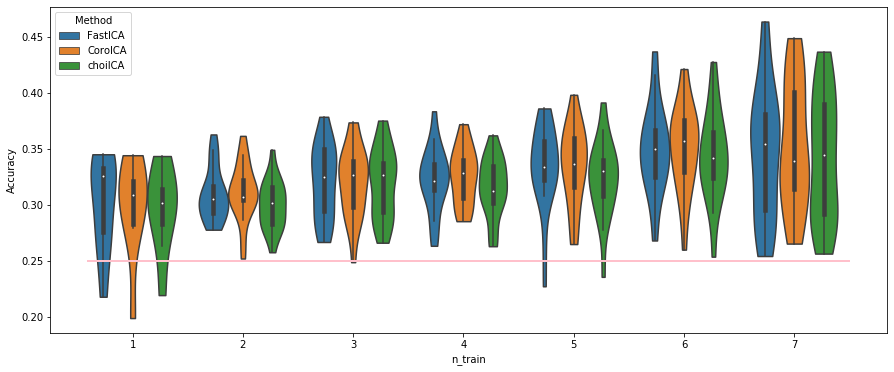

In [16]:
fig, ax1 = plt.subplots(figsize=(15, 6), sharex=True)
ax1 = sns.violinplot(x="n_train", y="Accuracy", hue="Method", inner = "box", cut=0,
                    data=df,ax = ax1)
plt.plot([-0.4, len(set(df["n_train"]))-0.5], [0.25, 0.25], linewidth=2, color = "pink")
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(15, 6), sharex=True)
ax1 = sns.catplot(x="n_train", y="Accuracy", hue="Method",
                    data=df1, kind="box",ax = ax1)

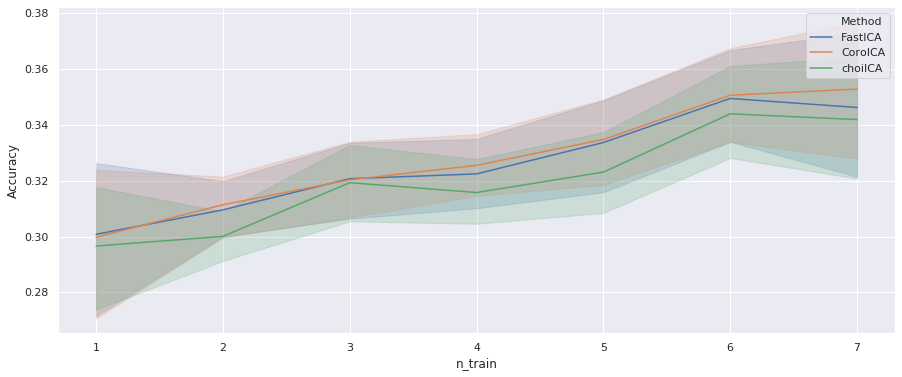

In [19]:
fig, ax1 = plt.subplots(figsize=(15, 6), sharex=True)
sns.lineplot(x="n_train", y="Accuracy", hue = "Method", data=df) #,style = "Classifier"
#plt.show()

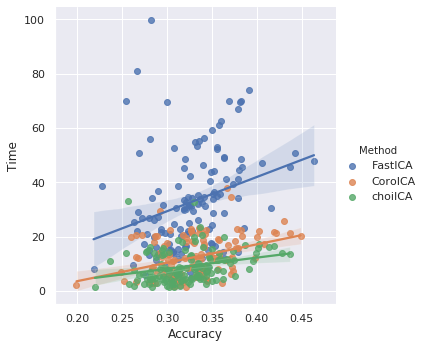

In [17]:
sns.set(rc={'figure.figsize':(16,8)})
sns.lmplot(y="Time", x="Accuracy",hue="Method", truncate = True, data=df)

In [ ]:
sns.regplot(y="Time", x="Accuracy", hue="Method", data=df1,
                 order=2, ci=None)

In [20]:
df1 = pd.read_pickle("Timed_QDA.pkl")
df1["Classifier"] = 192*["QDA"]
df2 = pd.read_pickle("Timed_MLP.pkl")
df2["Classifier"] = 192*["MLP"]
df3 = pd.read_pickle("Timed_ADA.pkl")
df3["Classifier"] = 3*8*9*["ADA"]
df4 = pd.read_pickle("Timed_RF.pkl")
df4["Classifier"] = 192*["RF"]

In [ ]:
np.mean((df2[(df2["n_train"]==6)])["Accuracy"])

In [ ]:
np.mean((df[(df["n_train"]==6)])["Accuracy"])

In [ ]:
df2 = pd.read_pickle("QDA_8subs.pkl")

In [ ]:
df_all = pd.concat([df1,df2,df3,df4])

In [ ]:
df_all["n_train"] = pd.to_numeric(df_all["n_train"])

In [22]:
df1 = pd.read_pickle("CAR_Filter_QDA.pkl")

In [ ]:
df1 = pd.concat([df,df2])